In this analysis we will be building a model to predict the legendary status of various PokeMon. My dataset contains the names, numbers, statistics, and status of each PokeMon, spanning all generations. There monsters listed that have various "forms" such as mega, among others. These do not represent novel monsters and I have removed them by dropping duplicate records by the monster number and keeping the first, original form.

I also recode the `legendary` column from boolean to string as well as using the `type_2` to only indicate whether a PokeMon is a dual type rather than the actual value (secondary types are sparsely populated as most PokeMon are single type).

I've also added the coefficient of variation statistics.

In [1]:
import pandas as pd
import numpy as np
import janitor

pk = pd.read_csv("pokemon.csv").\
drop_duplicates(subset=['#'],keep = 'first').\
drop(['#','Generation','Total'],axis = 1).\
clean_names().\
assign(legendary = lambda x: np.where(x['legendary'] == 1, 'Legend', 'Normal'),
      type_2 = lambda x: np.where(x['type_2'].isnull() == True, 'Single Type', 'Dual Type'),
      total = lambda x: x.iloc[:, 3:9].sum(numeric_only=True,axis=1).astype(int),
      rsd = lambda x: x.iloc[:, 3:9].std(numeric_only=True,axis=1)/x.iloc[:, 3:9].mean(numeric_only=True,axis=1))


pk = pk[~pk["name"].str.contains(" ")]

pk.groupby(['legendary']).sample(5)

,name,type_1,type_2,hp,attack,defense,sp_atk,sp_def,speed,legendary,total,rsd
706,Reshiram,Dragon,Dual Type,100,120,100,150,120,90,Legend,680,0.190610
162,Mewtwo,Psychic,Single Type,106,110,90,154,90,130,Legend,680,0.219184
548,Manaphy,Water,Single Type,100,100,100,100,100,100,Legend,600,0.000000
793,Yveltal,Dark,Dual Type,126,131,95,131,98,99,Legend,680,0.155921
263,Entei,Fire,Single Type,115,115,85,90,75,100,Legend,580,0.168930
364,Swablu,Normal,Dual Type,45,40,60,40,75,50,Normal,310,0.264437
356,Spoink,Psychic,Single Type,60,25,35,70,80,60,Normal,330,0.381385
736,Pyroar,Fire,Dual Type,86,68,72,109,66,106,Normal,507,0.226744
169,Cyndaquil,Fire,Single Type,39,52,43,60,50,65,Normal,309,0.191339
20,Pidgey,Normal,Dual Type,40,45,40,35,35,56,Normal,251,0.188476


I include the coefficient of variation (abbriviated `rsd` for "relative standard deviation") because it can be a strong predictor of legendary status. Lendendary PokeMon's individual stats are much less variable, as can be seen below.

In [3]:
pk.groupby(['legendary']).rsd.describe().reset_index()

,legendary,count,mean,std,min,25%,50%,75%,max
0,Legend,44.0,0.197710,0.129861,0.0,0.155877,0.190610,0.236368,0.572871
1,Normal,660.0,0.306768,0.154801,0.0,0.210906,0.280277,0.368564,1.343371


I'll plot the distribution between normal and legendary where we can see that Water types are the most frequently occuring PokeMon Type overall as well as for non-legendary. Legendary PokeMon are most often Psychic

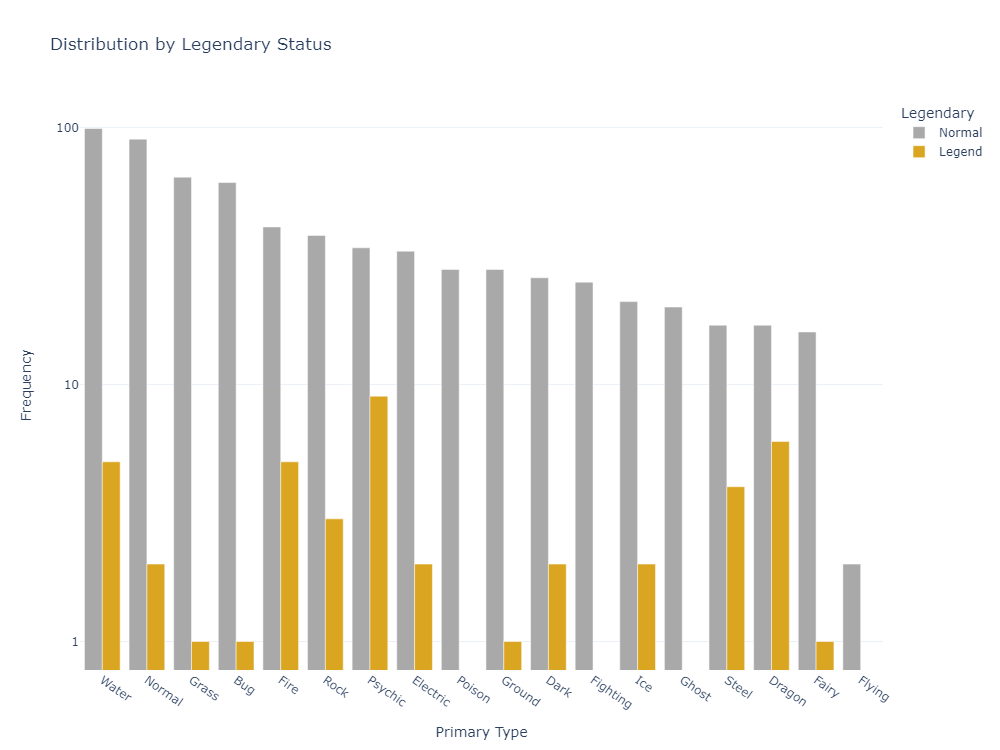

In [3]:
import plotly.express as px
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore") 

fig = px.bar(pk[['legendary','type_1']].\
             value_counts().\
             reset_index().\
             rename(columns={0:"Frequency"}).\
             sort_values(['legendary','Frequency'],ascending = False),
             x="type_1",
             y="Frequency",
             title="Distribution by Legendary Status",
                template="plotly_white",
                 barmode="group",
                 color_discrete_map = {"Normal":"darkgrey","Legend":"goldenrod"},
                 log_y=True,
                 color="legendary").\
update_xaxes(title="Primary Type",tickangle = 35).\
update_yaxes(dtick=1).\
update_layout(legend_title="Legendary")

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

When stratifying and examining by type we again see Psychic is the most common legendary type and water is the most common normal type, representing 20.5% and 15% respectively. Psychic types account for 1/5 of all legendary Pok typeMon with the next most frequent type (Dragon) a full 7% less.

Another point this reveals is that dragon types are rarely non legendary and Bug types are rarely legendary

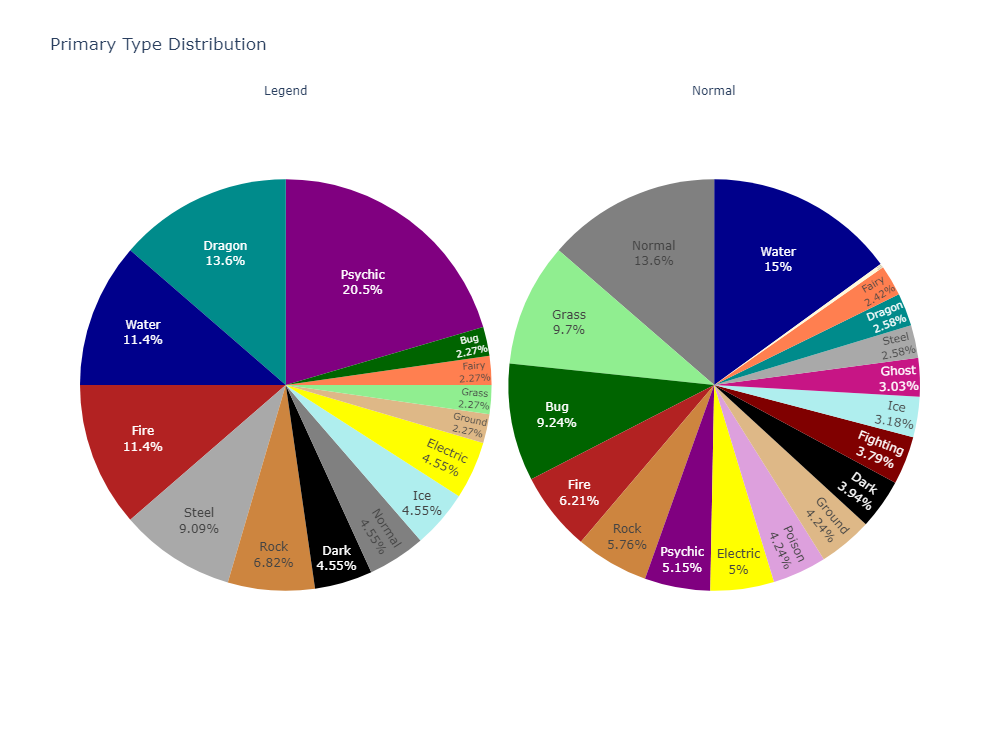

In [4]:
fig = px.pie(pk[['legendary','type_1']].\
             value_counts().\
             reset_index().\
             rename(columns={0:"Frequency"}).\
             sort_values(['legendary','Frequency']), values='Frequency',
             title="Primary Type Distribution",
       names='type_1',
       color="type_1",
       color_discrete_map={'Grass':"lightgreen", 'Fire':"firebrick", 'Water':"darkblue", 
                           'Bug':"darkgreen", 'Normal':"grey", 'Poison':"plum", 'Electric':"yellow",
       'Ground':"burlywood", 'Fairy':"coral", 'Fighting':"maroon", 'Psychic':"purple", 'Rock':"peru",
         'Ghost':"mediumvioletred ",'Ice':"paleturquoise",
       'Dragon':"darkcyan", 'Dark':"black", 'Steel':"darkgrey", 'Flying':"cornsilk"},
      facet_col="legendary").\
update_traces(textposition='inside', textinfo='percent+label').\
for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].replace("_"," ").title())).\
update_layout(showlegend=False)

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

Next I'll look at the distributions of each statistic.

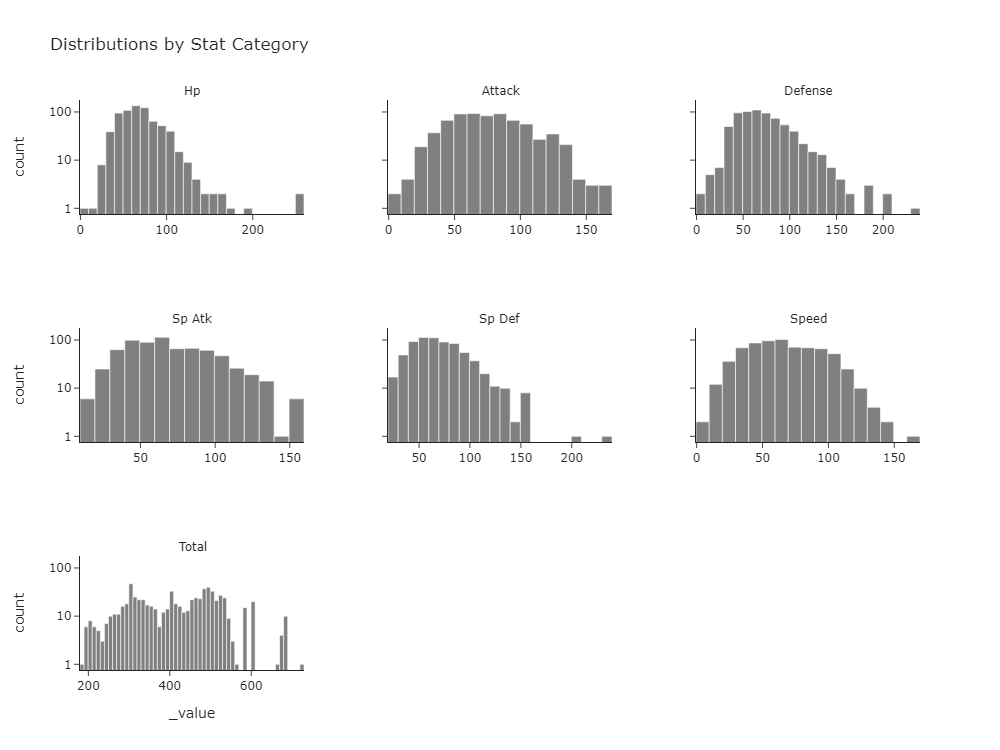

In [5]:
fig = px.histogram(pk.select_dtypes(np.number).drop(['rsd'],axis=1).melt(),
             facet_col="variable",facet_col_wrap=3,template="simple_white",
             log_y=True,
            color_discrete_sequence=['grey'],
            title="Distributions by Stat Category",
             facet_col_spacing = .10,
            facet_row_spacing = .20).\
update_yaxes(dtick=1).\
for_each_xaxis(lambda y: y.update(matches=None, showticklabels=True)).\
for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].replace("_"," ").title())).\
update_layout(showlegend=False)

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

I'll also examine the correlations between individual stats. As expected, the legendary monsters are primarily concentrated to the upper right of each graph, having high values for all of their stat categories.

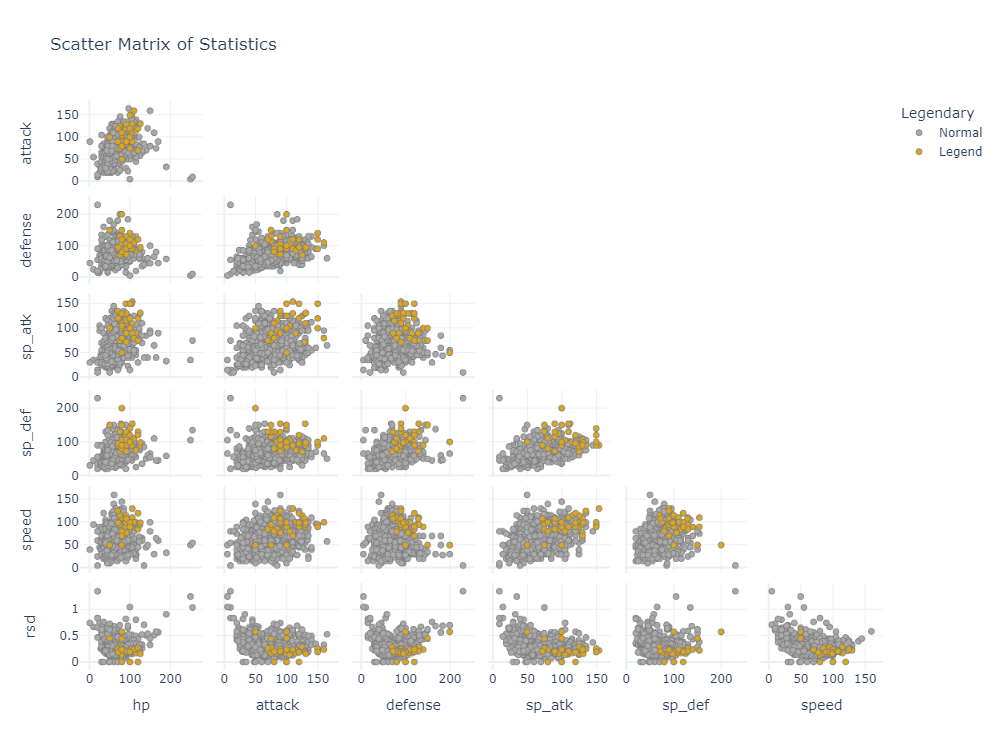

In [7]:
fig = px.scatter_matrix(pk,dimensions=pk.select_dtypes(np.number).drop(['total'],axis=1),
                  template="plotly_white",
                 color="legendary",
                 title="Scatter Matrix of Statistics",
                 color_discrete_map = {"Normal":"darkgrey","Legend":"goldenrod"}).\
update_traces(showupperhalf=False,diagonal_visible=False,marker_line_width=0.75,marker_line_color="grey").\
update_layout(legend_title="Legendary")

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

Before building our model, I will look at a simple correlation matrix to determine if any features can be combined, dropped, or decomposed.

The highest correlation coefficent is 0.49, which is considered strong, but if I look at the scatter matrix above, I can see a wide dispersion of the datapoints, so I will elect to leave all feature in.

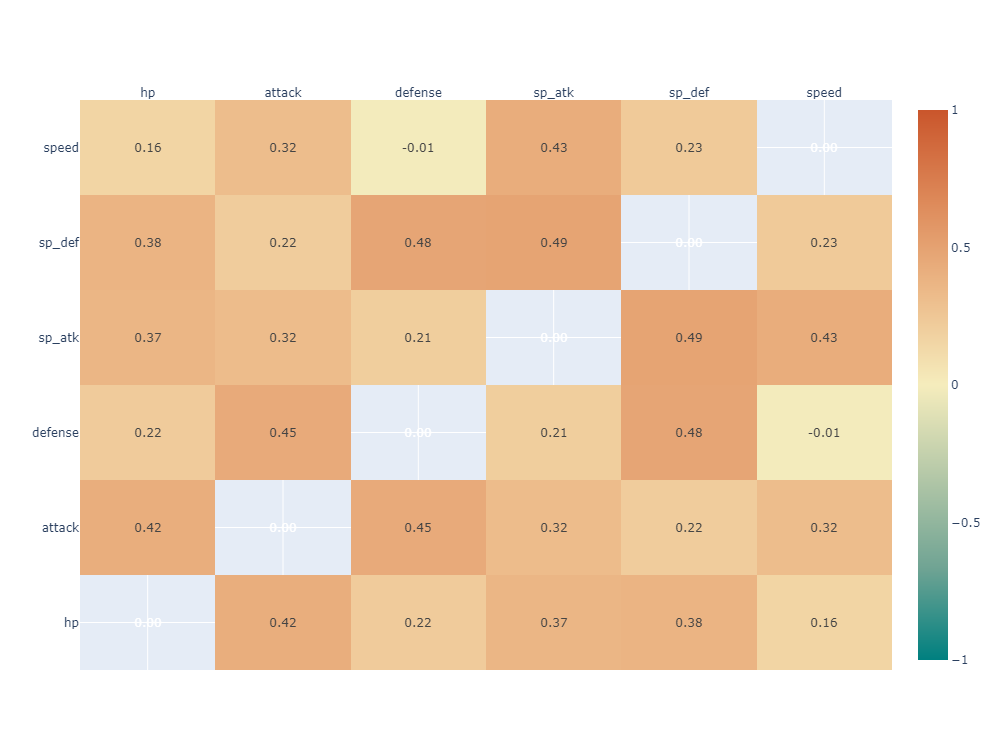

In [99]:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

corrplt =  pk.drop(pk.filter(like=r"total"),axis=1).drop(['rsd'],axis=1).corr()

fig = go.Figure(go.Heatmap(
        x = corrplt.columns,
        y = corrplt.index,
        z = np.array(corrplt.replace(1,np.nan)),
        text=corrplt.replace(1,np.nan).values,
        texttemplate='%{text:.2f}',
        colorscale = px.colors.diverging.Geyser,
         zmin=-1, zmax=1)).update_xaxes(side="top").\
         update_traces(hovertemplate='%{x} to %{y}<br> Correlation <b>%{z}')

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

After importing the modelling libraries I create a pieline and encode `type_1` and `type_2`. I will leave the other features unmodified.

I use a `RandomForestClassifier` and set the number of tress to 200 (100 greater than the default) and set `max_features` to `None` to capture all features.

Finally, I split into training and teting sets.

In [122]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import *
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler ,FunctionTransformer
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
target_name = "legendary"

In [126]:
pipe = make_pipeline(ColumnTransformer(
  transformers = [
  ('typeOHE',OneHotEncoder(max_categories=7),['type_1','type_2'])
  ],
  remainder = 'passthrough'),
  RandomForestClassifier(n_estimators=200,criterion="entropy",max_features=None))

train,test = train_test_split(pk,train_size = .75,stratify = pk[target_name])

X = train.drop(['name',target_name],axis = 1)
Y = np.array(train[[target_name]])

I fit and perform the prediction in one step and assign it to a new column in the `test` dataframe.

In [127]:
test[target_name+'predicted'] = pipe.fit(X, Y).predict(test.drop([target_name],axis = 1))

I check the f1 score, which is a combination of precision and recall metrics and commonly used to assess model performance on imbalanced data. A score > 0.90 is considered to be very good, so I can infer the model is reliably predicting the target class.

In [128]:
f1_score(test[target_name], test[target_name+'predicted'],pos_label='Legend')

0.9565217391304348

Here, I plot the confusion matrix to examine where the model incorrectly predicted the class. It appears it always predicted legendary monsters in the test set correctly, but classified 1 normal monster as legendary. Let's take a look at which monster that is...

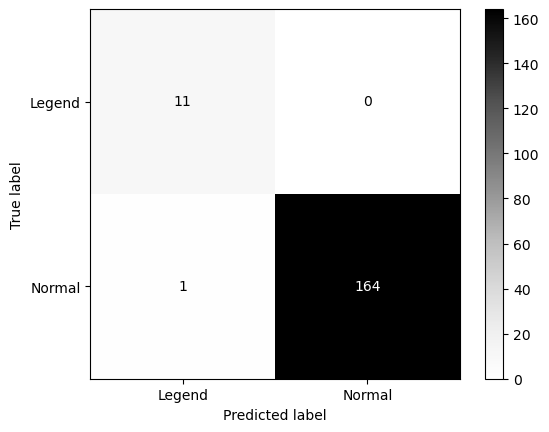

In [129]:
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(confusion_matrix(test[target_name], test[target_name+'predicted']),
                       display_labels=pipe.classes_).\
plot(cmap=plt.cm.Greys)

The misclassified PokeMon, Tyranitar, has very high statistic total. On some web forums and fan communities, Tyranitar would be considered to be "pseudo-legendary". This label is commonly used to refer to any Pokemon that has a three stage evolution and a base stat total of 600.

In [130]:
test.query("legendary != legendarypredicted")

,name,type_1,type_2,hp,attack,defense,sp_atk,sp_def,speed,legendary,total,rsd,legendarypredicted
267,Tyranitar,Rock,Dual Type,100,134,110,95,100,61,Normal,600,0.236728,Legend
